 ### INITIALIZATION OF WORKSPACE

In [1]:
import numpy as np
from scipy.spatial import distance
import pylab as pl
%pylab --no-import-all inline
import openturns as ot
from math import sqrt, sin, pi
import matplotlib.pyplot as plt
from Tools import fsm
from Tools import EWIS_func
from Tools.ViewPDF import*

Populating the interactive namespace from numpy and matplotlib


### INPUT DATA

#### Initialisation

In [2]:
Configuration= {}
Configuration['Scenario1'] = {'X_EPDC2':[10, 2, 0], 'V0':28, 'DeltaV':1, 'C1':1.2, 'C2':1.4, 'Workdir':'./Scenario1'}
Configuration['Scenario2'] = {'X_EPDC2':[28, 2, 0], 'V0':28, 'DeltaV':1, 'C1':1.2, 'C2':1.4, 'Workdir':'./Scenario2'}
Conf = Configuration['Scenario1']

In [3]:
# Data Gauge catalog
Catalog_Gauge = np.loadtxt('./Data/Catalog_gauge.csv', delimiter=';').reshape(17,4)[:,1:]

# Positions SPDB, VU
X_SPDB = [[20, 2, 2], [25, 2, 2], [30,2,2], [35,2,2], [40,2,2], [45,2,2], [50,2,2], [55,2,2]]
X_VU   = [[12,0,-2],[14,-2,-2],[14,2,-2]]

#Number of Equipments (PSU Eq for SPDB)
NbPSUBySPDB = 5  
NbPSU       = len (X_SPDB)* NbPSUBySPDB
NbEqByVU    = 15
NbEqVU      = len (X_VU)* NbEqByVU

#### Compute Harness Distance

In [4]:
# Instantiate function with "parameter" X_EPDC2
distance = ot.NumericalMathFunction(EWIS_func.DistanceFunc(Conf['X_EPDC2']))

# Compute lengths for a given EWIS architecture
Dist_SPDB = distance(X_SPDB)
Dist_VU   = distance(X_VU)

### Probabilistic model

#### SPDB

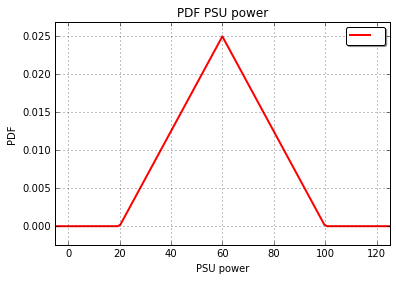

In [5]:
# Marginal law of PSU
distributionMarginal_PSU = ot.Triangular(20.,60.,100.)
viewPDF (distributionMarginal_PSU, 'PDF PSU power', 'PSU power','PDF',' ',Conf['Workdir']+'/PDF PSU.png')

# Independence b/t all PSU
distributionSPDB = ot.ComposedDistribution([distributionMarginal_PSU]*NbPSU)

#### VU

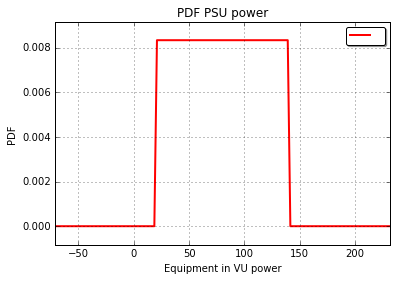

In [6]:
distributionMarginal_Eq = ot.Uniform(20.,140.)
viewPDF (distributionMarginal_Eq,'PDF PSU power', 'Equipment in VU power', 'PDF', ' ', Conf['Workdir']+'/PDF Eq.png')

distributionVU = ot.ComposedDistribution([distributionMarginal_Eq]*(NbEqVU))

### Propagation

#### Generate Sample

In [7]:
sizeSample = 100000
PowerSampleSPDB = distributionSPDB.getSample(sizeSample)
PowerSampleVU   = distributionVU.getSample(sizeSample)

#### Compute Mass & Diameter for SPBD

-------------------------------------------------------------------------------
Mass SPDB 

* ------ Deterministic analysis ------*
 Min =  11.88 Max =  19.29 Delta =  7.41


* ------ Probabilistic analysis ------*
 Quantile @ 50 =  16.08 
 Quantile @ 90 =  17.04 
 Quantile @ 99 =  18.24 
 Variance  =  1.14 
 Interquantile  (q(99,7) - q(0,3)) =  5.57 
 6-sigma =  6.42
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Diam SPDB 

* ------ Deterministic analysis ------*
 Min =  177.73 Max =  314.47 Delta =  136.74


* ------ Probabilistic analysis ------*
 Quantile @ 50 =  248.53 
 Quantile @ 90 =  269.93 
 Quantile @ 99 =  292.20 
 Variance  =  345.54 
 Interquantile  (q(99,7) - q(0,3)) =  101.34 
 6-sigma =  111.53
-------------------------------------------------------------------------------


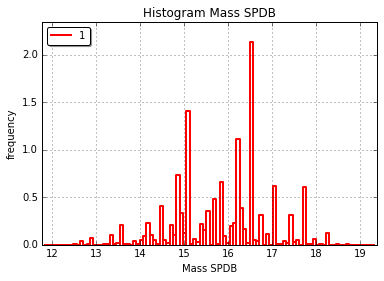

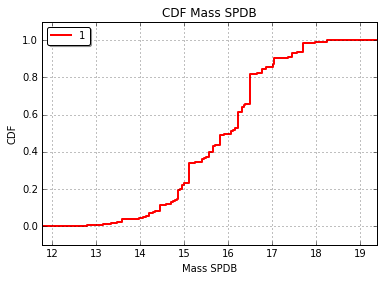

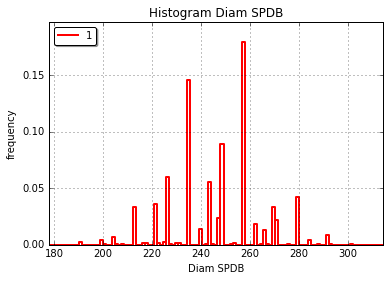

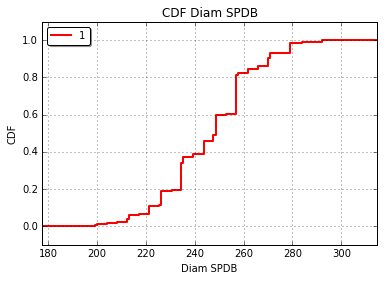

In [8]:
initMassSPDB  = EWIS_func.CalcMassFunc([NbPSUBySPDB, Conf['DeltaV']*Conf['V0']],(np.array(Dist_SPDB))[:,0],Catalog_Gauge)
modelMassSPDB = ot.NumericalMathFunction(initMassSPDB)

Y = modelMassSPDB(PowerSampleSPDB)
#Mass
MassSample_SPDB = Y.getMarginal(0)
MassSPDB_min = MassSample_SPDB.getMin()[0]
MassSPDB_max = MassSample_SPDB.getMax()[0]
fittedDist_Mass_SPDB = ot.KernelSmoothing().build(MassSample_SPDB)

viewResults(MassSample_SPDB, "Mass SPDB", MassSPDB_min-0.1, MassSPDB_max+0.1, Conf['Workdir'])

#Diameter
DiamSample_SPDB = Y.getMarginal(1)
DiamSPDB_min = DiamSample_SPDB.getMin()[0]
DiamSPDB_max = DiamSample_SPDB.getMax()[0]
fittedDist_Diam_SPDB = ot.KernelSmoothing().build(DiamSample_SPDB)

viewResults(DiamSample_SPDB, "Diam SPDB", DiamSPDB_min-0.1, DiamSPDB_max+0.1, Conf['Workdir'])



In [9]:
# Visualization of the sum of powers per SPDB vs the total mass of the architecture

#R1 = np.array(PowerSampleSPDB).reshape(sizeSample,len(X_SPDB), NbPSUBySPDB)
#Sum_Pow_SPDB = R1.sum(axis=2)

#v1 =fsm.functional_scatter_matrix(Sum_Pow_SPDB, MassSample_SPDB, ot.GreaterOrEqual(), color="blue", 
                                 #values = MassSample_SPDB.computeQuantile(0.99), colors = ["red"])
#v1._fig.set_size_inches(16, 12)


#### Compute Mass & Diameter for VU

-------------------------------------------------------------------------------
Mass VU 

* ------ Deterministic analysis ------*
 Min =  0.86 Max =  1.73 Delta =  0.87


* ------ Probabilistic analysis ------*
 Quantile @ 50 =  1.40 
 Quantile @ 90 =  1.58 
 Quantile @ 99 =  1.73 
 Variance  =  0.04 
 Interquantile  (q(99,7) - q(0,3)) =  0.62 
 6-sigma =  1.16
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Diam VU 

* ------ Deterministic analysis ------*
 Min =  58.08 Max =  119.74 Delta =  61.66


* ------ Probabilistic analysis ------*
 Quantile @ 50 =  93.48 
 Quantile @ 90 =  106.61 
 Quantile @ 99 =  119.74 
 Variance  =  207.35 
 Interquantile  (q(99,7) - q(0,3)) =  48.53 
 6-sigma =  86.40
-------------------------------------------------------------------------------


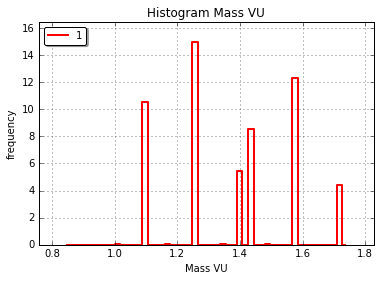

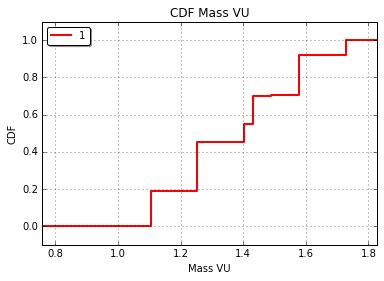

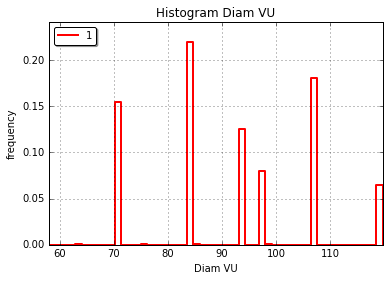

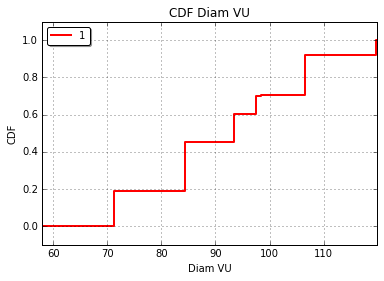

In [10]:
initMassVU = EWIS_func.CalcMassFunc([NbEqByVU, Conf['DeltaV']*Conf['V0']],(np.array(Dist_VU))[:,0],Catalog_Gauge)
modelMassVU = ot.NumericalMathFunction(initMassVU)

Y = modelMassVU(PowerSampleVU)
#Mass
MassSample_VU = Y.getMarginal (0)
MassVU_min = MassSample_VU.getMin()[0]
MassVU_max = MassSample_VU.getMax()[0]
fittedDist_Mass_VU = ot.KernelSmoothing().build(MassSample_VU)

viewResults(MassSample_VU, "Mass VU", MassVU_min-0.1, MassVU_max+0.1, Conf['Workdir'])

#Diameter
DiamSample_VU = Y.getMarginal (1)
DiamVU_min = DiamSample_VU.getMin()[0]
DiamVU_max = DiamSample_VU.getMax()[0]
fittedDist_Diam_VU = ot.KernelSmoothing().build(DiamSample_VU)

viewResults(DiamSample_VU, "Diam VU", DiamVU_min-0.1, DiamVU_max+0.1, Conf['Workdir'])


#### Compute Total Mass & Diameter 

In [11]:
Mass_TOT = ot.RandomMixture ([Conf['C1']*Conf['C2']*fittedDist_Mass_SPDB,Conf['C1']*Conf['C2']*fittedDist_Mass_VU ])

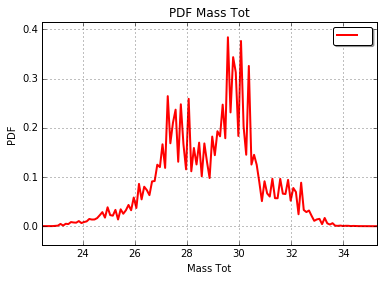

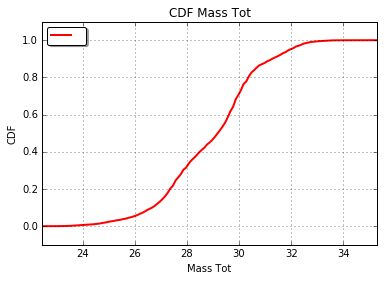

In [16]:
viewPDF (Mass_TOT, 'PDF Mass Tot', 'Mass Tot','PDF',' ',Conf['Workdir']+'/Mass TOTPDF.png')
viewCDF (Mass_TOT, 'CDF Mass Tot', 'Mass Tot','CDF',' ',Conf['Workdir']+'/Mass TOTCDF.png')

In [13]:
print " Quantile @ 90 = % .2f " %Mass_TOT.computeQuantile(0.90)[0]
print " Quantile @ 99 = % .2f " %Mass_TOT.computeQuantile(0.99)[0]

 Quantile @ 90 =  31.27 
 Quantile @ 99 =  32.75 
